In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
tf.constant(1.0)  # Trigger basic op
import logging
logging.getLogger('absl').setLevel(logging.ERROR)
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import ray
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import datetime
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

2025-08-20 00:15:47.231839: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-20 00:15:47.232760: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-20 00:15:47.237064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-20 00:15:47.248041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755666947.288380   79847 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755666947.30

In [2]:
%load_ext autoreload
%autoreload 2
from surface_coil_loader import load_full_dataset, load_split_datasets
from transformers_copy import TransformerEncoder, TransformerDecoder
from CoilAutoencoder_copy import CoilAutoencoderModel

In [3]:
tfrecord_dir = Path("mini_surface_coil_tfrecords")

In [4]:
def build_coil_autoencoder(hp):
    encoder = TransformerEncoder(max_sets=6, features_per_set=100, name='coil', embed_dim=hp["embed_dim"],
        num_heads=hp["num_heads"], ff_dim=hp["ff_dim"], 
        num_sab_blocks=hp["sab_blocks"], dropout=hp["enc_dropout"])
    
    decoder = TransformerDecoder(name = 'coil', embed_dim=hp["embed_dim"], num_heads=hp["num_heads"], ff_dim=hp["ff_dim"],
        num_layers=hp["decoder_blocks"], max_sets=6, features_per_set=100, dropout=hp["dec_dropout"])
    
    autoencoder = CoilAutoencoderModel(encoder, decoder)
    return autoencoder, encoder, decoder

In [5]:
def build_model(hp):
    model, encoder, decoder = build_coil_autoencoder(hp)    
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-7, decay_steps=423, 
                                                            warmup_target=hp['learning_rate'], warmup_steps=47)
    optimizer = tf.keras.optimizers.Lion(learning_rate=lr_schedule, weight_decay=hp['weight_decay'])
    model.compile(optimizer=optimizer)
    return model, encoder, decoder

In [6]:
def prepare_callbacks(log_dir, model_name="coil_autoencoder"):
    return [
        TensorBoard(log_dir=log_dir),
        ModelCheckpoint(
            filepath=os.path.join(log_dir, f"{model_name}_best.keras"),
            save_best_only=True,
            monitor='val_loss'
        )
    ]

In [7]:
example_hp = {'batch_size': 64,
 'embed_dim': 64,
 'num_heads': 4,
 'ff_dim': 128,
 'enc_dropout': 0.03687998002549748,
 'dec_dropout': 0.14346229179997497,
 'learning_rate': 1.0024438630534578e-05,
 'weight_decay': 0.0060082332950099505,
 'sab_blocks': 1,
 'decoder_blocks': 1}

In [8]:
def train_coil_autoencoder(hp, train_ds, val_ds, epochs, steps_per_epoch, log_root="logs", use_wandb=False):
    model, encoder, decoder = build_model(hp)

    run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join(log_root, f"{run_id}_trial")
    os.makedirs(log_dir, exist_ok=True)

    # total_steps = epochs * steps_per_epoch

    callbacks = prepare_callbacks(log_dir)

    if use_wandb:
        import wandb
        from wandb.keras import WandbCallback
        wandb.init(project="coil_autoencoder", config=hp)
        callbacks.append(WandbCallback())

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )

    encoder.save(os.path.join(log_dir, "encoder.keras"))
    decoder.save(os.path.join(log_dir, "decoder.keras"))
    return history, encoder, decoder

In [10]:
train_ds, val_ds, test_ds = load_split_datasets(tfrecord_dir, batch_size=example_hp["batch_size"])

history, encoder, decoder = train_coil_autoencoder(
    hp=example_hp,
    train_ds=train_ds,
    val_ds=val_ds,
    epochs=10,
    steps_per_epoch=47,
    log_root="coil_logs",
    use_wandb=False
)

2025-08-20 00:31:46.500930: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10


2025-08-20 00:31:51.398205: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


     37/Unknown 6s 30ms/step - coil_loss: 0.3234 - loss: 25.7124 - mae: 0.7012 - scaler_loss: 25.3890 - unmasked_mse: 0.7618

/home/isaac/anaconda3/envs/TFCoil/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - coil_loss: 0.3221 - loss: 25.2912 - mae: 0.7018 - scaler_loss: 24.9692 - unmasked_mse: 0.7635 - val_coil_loss: 0.3710 - val_loss: 15.0974 - val_mae: 0.7153 - val_scaler_loss: 14.7264 - val_unmasked_mse: 0.7932
Epoch 2/10


2025-08-20 00:31:53.803856: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/isaac/anaconda3/envs/TFCoil/lib/python3.9/site-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - coil_loss: 0.3770 - loss: 8.1213 - mae: 0.7293 - scaler_loss: 7.7443 - unmasked_mse: 0.8725 - val_coil_loss: 0.4584 - val_loss: 2.2284 - val_mae: 0.7467 - val_scaler_loss: 1.7700 - val_unmasked_mse: 0.9703
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - coil_loss: 0.4337 - loss: 1.8631 - mae: 0.7416 - scaler_loss: 1.4294 - unmasked_mse: 0.9962 - val_coil_loss: 0.5043 - val_loss: 0.6759 - val_mae: 0.7413 - val_scaler_loss: 0.1716 - val_unmasked_mse: 1.0635
Epoch 4/10


2025-08-20 00:31:58.410234: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - coil_loss: 0.4555 - loss: 0.9398 - mae: 0.7368 - scaler_loss: 0.4843 - unmasked_mse: 1.0492 - val_coil_loss: 0.5202 - val_loss: 0.5227 - val_mae: 0.7342 - val_scaler_loss: 0.0025 - val_unmasked_mse: 1.0946
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - coil_loss: 0.4617 - loss: 0.6526 - mae: 0.7299 - scaler_loss: 0.1908 - unmasked_mse: 1.0637 - val_coil_loss: 0.5239 - val_loss: 0.5489 - val_mae: 0.7230 - val_scaler_loss: 0.0250 - val_unmasked_mse: 1.1011
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - coil_loss: 0.4629 - loss: 0.5817 - mae: 0.7211 - scaler_loss: 0.1188 - unmasked_mse: 1.0663 - val_coil_loss: 0.5225 - val_loss: 0.6093 - val_mae: 0.7108 - val_scaler_loss: 0.0868 - val_unmasked_mse: 1.0974
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - coil_loss: 0.4610 - loss: 0.5594 - mae: 0.7124 - scaler_loss: 0.0984 - unmasked_mse: 1.0612 - val_coil_loss: 0.5171 - val_loss: 0.6523 - val_mae: 0.6993 - val_scaler_loss: 0.1352 - 

2025-08-20 00:32:06.671418: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - coil_loss: 0.4585 - loss: 0.5513 - mae: 0.7036 - scaler_loss: 0.0929 - unmasked_mse: 1.0488 - val_coil_loss: 0.5082 - val_loss: 0.6518 - val_mae: 0.6903 - val_scaler_loss: 0.1436 - val_unmasked_mse: 1.0662
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - coil_loss: 0.4467 - loss: 0.5296 - mae: 0.6948 - scaler_loss: 0.0829 - unmasked_mse: 1.0307 - val_coil_loss: 0.4985 - val_loss: 0.6238 - val_mae: 0.6829 - val_scaler_loss: 0.1253 - val_unmasked_mse: 1.0454
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - coil_loss: 0.4398 - loss: 0.5122 - mae: 0.6880 - scaler_loss: 0.0724 - unmasked_mse: 1.0129 - val_coil_loss: 0.4908 - val_loss: 0.5937 - val_mae: 0.6777 - val_scaler_loss: 0.1029 - val_unmasked_mse: 1.0289


<Axes: >

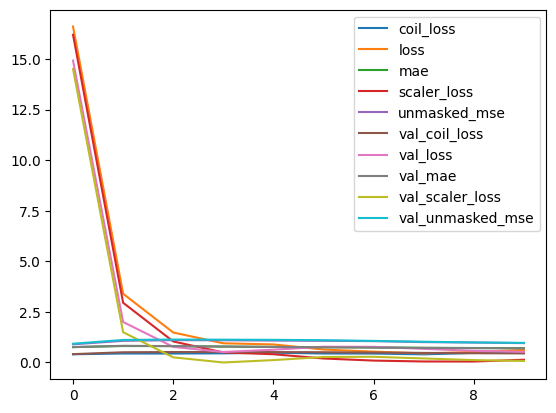

In [34]:
pd.DataFrame(history.history).plot()

In [17]:
batched_dataset = load_full_dataset(tfrecord_dir, batch_size = example_hp['batch_size'])

In [40]:
from transformers import SelfAttentionBlock, PoolingByMultiheadAttention
# encoder = tf.keras.models.load_model('coil_logs/20250812-152016_trial/encoder.keras', safe_mode=False)
encoder = tf.keras.models.load_model(
    "coil_logs/20250817-144615_trial/encoder.keras",
    custom_objects={"SelfAttentionBlock": SelfAttentionBlock, 
                    'PoolingByMultiheadAttention': PoolingByMultiheadAttention},
    safe_mode=False, compile=False
)

In [41]:
for batch, _ in batched_dataset.take(1):
    coil_data = batch["coil_data"]
    coil_mask = batch["coil_mask"]
    surface_data = batch["surface_data"]  # assumes surface is already included in parse_tfrecord_fn
    surface_mask = batch['surface_mask']

    coil_latents = encoder(
            {"coil_data": coil_data, "coil_mask": coil_mask},
            training=False
        )

AttributeError: Exception encountered when calling Lambda.call().

[1m'dict' object has no attribute 'ones_like'[0m

Arguments received by Lambda.call():
  • inputs=tf.Tensor(shape=(64, 6), dtype=float32)
  • mask=None
  • training=False

In [14]:
import numpy as np
import tensorflow as tf

def _float_feature(value):
    """Returns a float_list from a tensor, numpy array, or list."""
    if isinstance(value, tf.Tensor):
        value = value.numpy()
    return tf.train.Feature(float_list=tf.train.FloatList(value=value.reshape(-1).astype(np.float32)))

def _int64_feature(value):
    """Returns an int64_list from a tensor, numpy array, or list."""
    if isinstance(value, tf.Tensor):
        value = value.numpy()
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value.reshape(-1).astype(np.int64)))

def serialize_example(coil_data, coil_mask, surface_data, surface_mask, coil_latent):
    feature = {
        "coil_data": _float_feature(coil_data),         # (TOTAL_ROWS, FEATURES_PER_COIL)
        "coil_mask": _int64_feature(coil_mask),         # (MAX_COILS,)
        "surface_data": _float_feature(surface_data),   # (TOTAL_SETS, FEATURES_PER_SET)
        "surface_mask": _int64_feature(surface_mask),   # (TOTAL_SETS,)
        "coil_latent": _float_feature(coil_latent),     # (latent_dim,)
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()


In [15]:
def write_latent_augmented_tfrecord(dataset, encoder, output_dir, max_records_per_file=10000):
    os.makedirs(output_dir, exist_ok=True)
    file_count = 0
    record_count = 0
    writer = None

    for batch, _ in tqdm(dataset, desc="Encoding & Writing"):
        coil_data = batch["coil_data"]
        coil_mask = batch["coil_mask"]
        surface_data = batch["surface_data"]  # assumes surface is already included in parse_tfrecord_fn
        surface_mask = batch['surface_mask']

        # Predict latents
        coil_latents = encoder(
            {"coil_data": coil_data, "coil_mask": coil_mask},
            training=False
        )

        for i in range(coil_data.shape[0]):
            if writer is None or record_count >= max_records_per_file:
                if writer:
                    writer.close()
                tfrecord_path = os.path.join(output_dir, f"augmented_{file_count:03d}.tfrecord")
                writer = tf.io.TFRecordWriter(tfrecord_path)
                file_count += 1
                record_count = 0

            serialized = serialize_example(coil_data[i], coil_mask[i], surface_data[i], surface_mask[i], coil_latents[i])
            writer.write(serialized)
            record_count += 1

    if writer:
        writer.close()


In [ ]:
latent_dir = Path('mini_latents_tfrecords')
write_latent_augmented_tfrecord(batched_dataset, encoder, latent_dir)